In [35]:
import pandas as pd
df = pd.read_csv('data/OBY01CRGEN.csv')
df
# uncomment with cmd + k + u

,Ukazatel,IndicatorType,Roky,CasR2A,Území,Uz0,Hodnota
0,Úhrnná plodnost,5405W,2023,2023,Česko,CZ,1.452572
1,Úhrnná plodnost,5405W,2022,2022,Česko,CZ,1.617747
2,Úhrnná plodnost,5405W,2021,2021,Česko,CZ,1.826536
3,Úhrnná plodnost,5405W,2020,2020,Česko,CZ,1.707373
4,Úhrnná plodnost,5405W,2019,2019,Česko,CZ,1.708963
...,...,...,...,...,...,...,...
1156,Průměrný věk žen při prvním sňatku,7182Z,1965,1965,Česko,CZ,21.700006
1157,Průměrný věk žen při prvním sňatku,7182Z,1964,1964,Česko,CZ,21.534990
1158,Průměrný věk žen při prvním sňatku,7182Z,1963,1963,Česko,CZ,21.342171
1159,Průměrný věk žen při prvním sňatku,7182Z,1962,1962,Česko,CZ,21.359491


In [36]:
# Keep only what you want (drops the rest)
df = df[["Roky", "Ukazatel", "Hodnota"]].copy()

In [37]:
# Custom transformation to wide format
df_wide = (
    df
    .pivot_table(
        index="Roky",
        columns="Ukazatel",
        values="Hodnota",
        aggfunc="mean"   # safe even if duplicates appear later
    )
    .reset_index()
    .sort_values("Roky")
)

# optional: ensure numeric dtype
for col in df_wide.columns:
    if col != "Roky":
        df_wide[col] = pd.to_numeric(df_wide[col], errors="coerce")

df_wide.to_csv('data/OBY01CRGEN_transformed.csv', index=False, encoding='utf-8-sig')
df = df_wide

In [38]:
import pandas as pd
import numpy as np
import altair as alt

class DataIntake:
    """
    Ultimate ML Pipeline: Section 1.3 - The Nuclear Intake
    Forces data types and uncovers hidden 'String' nulls.
    """
    def __init__(self, df):
        self.df = df.copy()
        self.report = {}

    def _force_discovery(self):
        """
        Attempts to convert every column to numeric. 
        If a cell contains 'Missing value' or text, it becomes np.nan.
        """
        for col in self.df.columns:
            # Skip columns that are clearly intended to be categorical/text
            if self.df[col].dtype == 'object' or self.df[col].dtype == 'string':
                # Attempt conversion; text that can't be a number becomes NaN
                converted = pd.to_numeric(self.df[col], errors='coerce')
                
                # Only update the column if it successfully found numbers
                # (This prevents turning a 'City' name column into all NaNs)
                if converted.notnull().sum() > 0:
                    self.df[col] = converted

    def profile_data(self):
        # 1. Run the discovery first
        self._force_discovery()
        
        # 2. Count actual NaNs now that they are coerced
        null_counts = self.df.isnull().sum().reset_index()
        null_counts.columns = ['column', 'missing_count']
        null_counts['missing_pct'] = (null_counts['missing_count'] / len(self.df)) * 100
        
        # 3. Dynamic Type Tagging
        types = []
        for col in self.df.columns:
            if pd.api.types.is_numeric_dtype(self.df[col]):
                types.append("Continuous Numerical")
            else:
                types.append("Categorical/Text")
        
        null_counts['semantic_type'] = types
        self.report = null_counts
        return self.report

    def plot_dna(self):
        # We add a small baseline (0.5) so you can see a tiny bar 
        # even if the data is 0% missing, ensuring the X-axis labels appear.
        chart = alt.Chart(self.report).mark_bar(size=20).encode(
            x=alt.X('column:N', sort='-y', title="Feature Names (Czech)"),
            y=alt.Y('missing_pct:Q', title="Missing Data (%)", scale=alt.Scale(domain=[0, 100])),
            color=alt.condition(
                alt.datum.missing_pct > 0,
                alt.value('#FF3366'),  # Neon Pink for missing
                alt.value('#00CC96')   # Green for clean
            ),
            tooltip=['column', 'missing_pct']
        ).properties(width=800, height=400, title="Data DNA: Corrected Null Detection")
        
        return chart


# --- Usage Example --- 
intake = DataIntake(df)
profile = intake.profile_data()
print(profile)
intake.plot_dna().display()


                                          column  missing_count  missing_pct  \
0                                           Roky              0     0.000000   
1                          Hrubá míra reprodukce              0     0.000000   
2                             Naděje dožití mužů              0     0.000000   
3                              Naděje dožití žen              0     0.000000   
4   Průměrná délka trvání manželství při rozvodu             11    10.576923   
5      Průměrný věk matek při narození 1. dítěte              5     4.807692   
6         Průměrný věk matek při narození dítěte              0     0.000000   
7            Průměrný věk mužů při prvním sňatku             41    39.423077   
8             Průměrný věk žen při prvním sňatku             41    39.423077   
9              Tabulková prvosňatečnost mužů (%)             41    39.423077   
10              Tabulková prvosňatečnost žen (%)             41    39.423077   
11                               Úhrnná 

alt.Chart(...)

For comparison of production and training df 

In [ ]:
from scipy.stats import ks_2samp
import plotly.graph_objects as go
import plotly.express as px

class DriftDetector(DataIntake):
    """
    Ultimate ML Pipeline: Section 1.1 - Drift & Shift Monitoring
    Compares Reference vs. Current data distributions.
    """
    def __init__(self, ref_df, cur_df):
        super().__init__(cur_df)
        self.ref_df = ref_df
        self.cur_df = cur_df
        self.drift_report = {}

    def detect_drift(self, threshold=0.05):
        """
        Performs KS-Test for numerical features. 
        P-value < threshold implies the distributions have drifted.
        """
        drift_results = []
        num_cols = self.cur_df.select_dtypes(include=[np.number]).columns
        
        for col in num_cols:
            stat, p_val = ks_2samp(self.ref_df[col].dropna(), self.cur_df[col].dropna())
            drift_results.append({
                'feature': col,
                'ks_stat': stat,
                'p_value': p_val,
                'is_drifted': p_val < threshold
            })
            
        self.drift_report = pd.DataFrame(drift_results)
        return self.drift_report

    def plot_drift_radar(self):
        """
        A modern Plotly Radar chart to visualize drift across features.
        The closer the line is to the center, the more 'stable' the feature is.
        """
        # Using (1 - KS-Stat) as 'Stability Score' for the radar
        fig = go.Figure()

        fig.add_trace(go.Scatterpolar(
            r=1 - self.drift_report['ks_stat'],
            theta=self.drift_report['feature'],
            fill='toself',
            name='Feature Stability',
            marker=dict(color='#00CC96')
        ))

        fig.update_layout(
            polar=dict(
                radialaxis=dict(visible=True, range=[0, 1])
            ),
            showlegend=True,
            title="Feature Stability Radar (1 = No Drift, 0 = High Drift)",
            template="plotly_dark"
        )
        return fig

# --- Usage Example ---
# detector = DriftDetector(training_df, production_df)
# drift_df = detector.detect_drift()
# detector.plot_drift_radar().show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
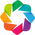

:Layout
   .Overlay.I    :Overlay
      .Curve.I   :Curve   [Roky]   (Hrubá míra reprodukce)
      .Scatter.I :Scatter   [Roky]   (Hrubá míra reprodukce)
   .Overlay.II   :Overlay
      .Curve.I   :Curve   [Roky]   (Naděje dožití mužů)
      .Scatter.I :Scatter   [Roky]   (Naděje dožití mužů)
   .Overlay.III  :Overlay
      .Curve.I   :Curve   [Roky]   (Naděje dožití žen)
      .Scatter.I :Scatter   [Roky]   (Naděje dožití žen)
   .Overlay.IV   :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrná délka trvání manželství při rozvodu)
      .Scatter.I :Scatter   [Roky]   (Průměrná délka trvání manželství při rozvodu)
   .Overlay.V    :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk matek při narození 1. dítěte)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk matek při narození 1. dítěte)
   .Overlay.VI   :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk matek při narození dítěte)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk matek při narození dítěte)
   .Overlay.VII  :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk mužů při prvním sňatku)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk mužů při prvním sňatku)
   .Overlay.VIII :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk žen při prvním sňatku)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk žen při prvním sňatku)
   .Overlay.IX   :Overlay
      .Curve.I   :Curve   [Roky]   (Tabulková prvosňatečnost mužů (%))
      .Scatter.I :Scatter   [Roky]   (Tabulková prvosňatečnost mužů (%))
   .Overlay.X    :Overlay
      .Curve.I   :Curve   [Roky]   (Tabulková prvosňatečnost žen (%))
      .Scatter.I :Scatter   [Roky]   (Tabulková prvosňatečnost žen (%))
   .Overlay.XI   :Overlay
      .Curve.I   :Curve   [Roky]   (Úhrnná plodnost)
      .Scatter.I :Scatter   [Roky]   (Úhrnná plodnost)
   .Overlay.XII  :Overlay
      .Curve.I   :Curve   [Roky]   (Úhrnná rozvodovost (%))
      .Scatter.I :Scatter   [Roky]   (Úhrnná rozvodovost (%))
   .Overlay.XIII :Overlay
      .Curve.I   :Curve   [Roky]   (Čistá míra reprodukce)
      .Scatter.I :Scatter   [Roky]   (Čistá míra reprodukce)

In [42]:
import holoviews as hv
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

hv.extension('bokeh')

class OutlierLab:
    """
    Automated Outlier Detection + Time-series plots for ALL numeric variables.
    """
    def __init__(self, df, time_col="Roky"):
        self.df = df.copy()
        self.time_col = time_col

        if self.time_col not in self.df.columns:
            raise ValueError(f"time_col='{self.time_col}' not found in df columns.")

        # Detect numeric columns, excluding time_col if it's numeric
        self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        if self.time_col in self.numeric_cols:
            self.numeric_cols.remove(self.time_col)

    def detect_outliers(self, contamination=0.05):
        iso = IsolationForest(contamination=contamination, random_state=42)

        temp_data = self.df[self.numeric_cols].fillna(self.df[self.numeric_cols].median())
        self.df["is_outlier"] = iso.fit_predict(temp_data)
        self.df["is_outlier"] = self.df["is_outlier"].map({1: "Inlier", -1: "Outlier"})
        return self.df

    def plot_all_timeseries(self, ncols=2, width=650, height=250, show_outliers=True):
        """
        One time-series per numeric variable.
        If show_outliers=True and detect_outliers() was run, overlays outlier points.
        """
        # Sort by time for proper lines
        dfp = self.df.sort_values(self.time_col).copy()

        plots = []
        for col in self.numeric_cols:
            line = hv.Curve(dfp, kdims=[self.time_col], vdims=[col]).opts(
                width=width,
                height=height,
                title=col,
                tools=["hover"],
                show_grid=False,
            )

            if show_outliers and "is_outlier" in dfp.columns:
                out_pts = dfp[dfp["is_outlier"] == "Outlier"]
                pts = hv.Scatter(out_pts, kdims=[self.time_col], vdims=[col]).opts(
                    size=6,
                    color="#FF3366",
                    marker="circle",
                    tools=["hover"],
                )
                plots.append(line * pts)
            else:
                plots.append(line)

        return hv.Layout(plots).cols(ncols)

# --- Usage Example ---
lab = OutlierLab(df, time_col="Roky")
lab.detect_outliers(contamination=0.04)   # optional
lab.plot_all_timeseries(ncols=2)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
import pandas as pd
import numpy as np

class FeatureTransformer:
    """
    Ultimate ML Pipeline: Section 3 - Preprocessing Suite
    Automatically routes features to the correct transformation logic.
    """
    def __init__(self, df, target_col=None):
        self.df = df.copy()
        self.target_col = target_col
        self.numeric_features = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_features = self.df.select_dtypes(exclude=[np.number]).columns.tolist()
        
        # Remove target and outlier flag from feature list
        for col in [target_col, 'is_outlier']:
            if col in self.numeric_features: self.numeric_features.remove(col)
            if col in self.categorical_features: self.categorical_features.remove(col)

    def build_processor(self, use_knn_imputer=False, scaling_type='robust'):
        """
        Creates a Scikit-Learn ColumnTransformer for automated processing.
        """
        # 1. Numeric Path: Impute -> Scale
        num_imputer = KNNImputer(n_neighbors=5) if use_knn_imputer else SimpleImputer(strategy='median')
        scaler = RobustScaler() if scaling_type == 'robust' else StandardScaler()
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', num_imputer),
            ('scaler', scaler)
        ])

        # 2. Categorical Path: Impute -> Encode
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # 3. Combine into the Universal Processor
        self.processor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ]
        )
        return self.processor

    def fit_transform(self):
        """Executes the pipeline and returns a cleaned DataFrame with names."""
        processed_data = self.processor.fit_transform(self.df)
        
        # Recover feature names for the modern aesthetic
        cat_names = self.processor.named_transformers_['cat'].get_feature_names_out(self.categorical_features)
        all_col_names = self.numeric_features + list(cat_names)
        
        return pd.DataFrame(processed_data, columns=all_col_names)

# --- Usage Example ---
transformer = FeatureTransformer(df, target_col='Hodnota')
transformer.build_processor(scaling_type='robust')
clean_df = transformer.fit_transform()